# Smart Price Optimization System  
_A data-driven system to recommend optimal product prices to maximize sales and revenue_


## 2. Acceptance Criteria  
The project will be considered successful if:  
1. **Revenue uplift ≥ 5%** in backtests compared to historical actual revenue.  
2. **Prediction error (RMSE)** at least 15% lower than naive baseline (last period’s sales).  
3. Price recommendations remain within **±30% of current price** (safety).  
4. Feature importance shows business-relevant drivers (price, competitor price, seasonality). 

# Imports

In [2]:
!pip install pandas numpy matplotlib seaborn scikit-learn xgboost joblib openpyxl


In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings("ignore")

from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.cluster import KMeans
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor



In [2]:
#!pip install --upgrade xgboost

# Load Dataset

In [3]:
df = pd.read_excel('online_retail_II.xlsx')

In [4]:
df.shape

(525461, 8)

In [5]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


# Data Preprocessing

Steps:
1. Convert `InvoiceDate` to datetime
2. Remove negative/zero quantities & prices
3. Remove cancellations (InvoiceNo starting with 'C')
4. Standardize text in `Description`
5. Compute revenue per row
6. Handle missing value
7. remove dublicate

In [6]:
missing = df.isna().sum().sort_values(ascending=False)
print(missing)

Customer ID    107927
Description      2928
StockCode           0
Invoice             0
Quantity            0
InvoiceDate         0
Price               0
Country             0
dtype: int64


In [7]:
df = df.dropna(subset=['Customer ID'])

In [8]:
df.drop_duplicates(inplace=True)

In [9]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df = df[(df['Price'] > 0) & (df['Quantity'] > 0)]
df = df[~df['Invoice'].astype(str).str.startswith('C')]
df['Description'] = df['Description'].astype(str).str.strip().str.lower()
df['revenue'] = df['Price'] * df['Quantity']


In [10]:
print("After cleaning shape:", df.shape,)
display(df.head())


After cleaning shape: (400916, 9)


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,revenue
0,489434,85048,15cm christmas glass ball 20 lights,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,pink cherry lights,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,white cherry lights,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"record frame 7"" single size",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,strawberry ceramic trinket box,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


In [11]:
df.shape

(400916, 9)

## Clean Data

In [12]:
# os.makedirs("data", exist_ok=True)
# df.to_csv("data/online_retail_ii_clean.csv", index=False)


In [13]:
#df = pd.read_csv("data/online_retail_ii_clean.csv")

In [14]:
# --- Split Retail vs Wholesale Customers ---
BULK_THRESHOLD = 500   # e.g., if order > 500 units = wholesale

df['order_type'] = np.where(df['Quantity'] > BULK_THRESHOLD, 'wholesale', 'retail')

print(df['order_type'].value_counts())


order_type
retail       400374
wholesale       542
Name: count, dtype: int64


In [15]:
# retail_df = df[df['order_type']=='retail']
# wholesale_df = df[df['order_type']=='wholesale']


# Aggregate Data to Product x Week Level

- Convert InvoiceDate to week (start of week)
- Aggregate metrics: avg_price, total_quantity, total_revenue, number of transactions
- Filter SKUs with enough history

In [16]:
df['week'] = df['InvoiceDate'].dt.to_period('W').apply(lambda r: r.start_time)

agg = df.groupby(['StockCode','week']).agg(
    avg_price = ('Price','mean'),
    total_quantity = ('Quantity','sum'),
    total_revenue = ('revenue','sum'),
    n_transactions = ('Invoice','nunique')
).reset_index()

agg = agg[agg['total_quantity'] > 0]

In [17]:
display(df.head())

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,revenue,order_type,week
0,489434,85048,15cm christmas glass ball 20 lights,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4,retail,2009-11-30
1,489434,79323P,pink cherry lights,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,retail,2009-11-30
2,489434,79323W,white cherry lights,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,retail,2009-11-30
3,489434,22041,"record frame 7"" single size",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8,retail,2009-11-30
4,489434,21232,strawberry ceramic trinket box,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0,retail,2009-11-30


 ## Handling Outlier

In [18]:
# Winsorize (clip) total_quantity and avg_price to reasonable percentiles
def handle_outliers(df, qty_col='total_quantity', price_col='avg_price', qty_pct=0.995, price_pct=0.995):
    q_max = df[qty_col].quantile(qty_pct)
    q_min = df[qty_col].quantile(1 - qty_pct) if df[qty_col].min() < 0 else 0
    p_max = df[price_col].quantile(price_pct)
    p_min = df[price_col].quantile(1 - price_pct)
    df[qty_col] = df[qty_col].clip(lower=q_min, upper=q_max)
    df[price_col] = df[price_col].clip(lower=p_min, upper=p_max)
    return df

# Apply to aggregated data before feature creation
agg = handle_outliers(agg, qty_pct=0.995, price_pct=0.995)


# Keep SKUs with at least 8 weeks of history

In [19]:
MIN_WEEKS = 8
sku_counts = agg['StockCode'].value_counts()
valid_skus = sku_counts[sku_counts >= MIN_WEEKS].index
agg = agg[agg['StockCode'].isin(valid_skus)].copy()

In [20]:
print("Aggregated shape after filtering SKUs:", agg.shape)
display(agg.head(10))
agg.to_csv("data/aggregated_weekly.csv", index=False)

Aggregated shape after filtering SKUs: (85201, 6)


,StockCode,week,avg_price,total_quantity,total_revenue,n_transactions
0,10002,2009-11-30,0.85,140.0,119.00,10
1,10002,2009-12-07,0.85,23.0,19.55,3
2,10002,2009-12-14,0.85,36.0,30.60,2
3,10002,2009-12-21,0.85,13.0,11.05,2
4,10002,2010-01-04,0.85,15.0,12.75,2
5,10002,2010-01-11,0.85,191.0,162.35,4
6,10002,2010-01-18,0.85,40.0,34.00,4
7,10002,2010-01-25,0.85,43.0,36.55,5
8,10002,2010-02-01,0.85,15.0,12.75,2
9,10002,2010-02-08,0.85,43.0,36.55,3


 # FEATURE ENGINEERING
 Create additional columns to help the model:
1. Time-based features: month, week_of_year, December flag, weekend flag
2. Simulated competitor price & price_diff/ratio
3. Lag features: previous weeks' quantity and price
4. Rolling mean features
5. Target transformation: log1p(total_quantity)
6. SKU clustering for categorical feature
7. Business Features

In [21]:
# Time features
agg['month'] = agg['week'].dt.month
agg['week_of_year'] = agg['week'].dt.isocalendar().week
agg['is_december'] = (agg['month'] == 12).astype(int)
agg['is_weekend_period'] = (agg['week'].dt.weekday >= 5).astype(int)

In [22]:
#  Simulated Competitor Data 
comp_df = pd.read_csv("competitor_price.csv", parse_dates=["week"])

# Merge competitor prices into agg (by StockCode + week)
agg = agg.merge(comp_df[['StockCode','week','competitor_price']], 
                on=['StockCode','week'], how='left')

# If competitor price missing (not found in CSV), fallback to avg_price
agg['competitor_price'] = agg['competitor_price'].fillna(agg['avg_price'])

# Create features
agg['price_diff'] = agg['avg_price'] - agg['competitor_price']
agg['price_ratio'] = agg['avg_price'] / (agg['competitor_price'] + 1e-9)


In [23]:
print(comp_df.columns)


Index(['StockCode', 'week', 'our_price', 'competitor_price'], dtype='object')


In [24]:
# Lag & rolling features
agg = agg.sort_values(['StockCode','week']).reset_index(drop=True)
agg['qty_lag_1'] = agg.groupby('StockCode')['total_quantity'].shift(1)
agg['qty_lag_2'] = agg.groupby('StockCode')['total_quantity'].shift(2)
agg['price_lag_1'] = agg.groupby('StockCode')['avg_price'].shift(1)
agg['qty_roll_3'] = agg.groupby('StockCode')['total_quantity'].shift(1).rolling(3).mean().reset_index(level=0, drop=True)

In [25]:
# Drop rows with NaNs in critical lag features
agg_feat = agg.dropna(subset=['qty_lag_1','qty_roll_3']).copy()

In [26]:
# Transform target
agg_feat['y_qty_log1p'] = np.log1p(agg_feat['total_quantity'])

In [27]:
sku_meta = agg_feat.groupby('StockCode').agg(
    avg_price_global=('avg_price','mean'),
    total_revenue_global=('total_revenue','sum')
).reset_index()
N_CLUSTERS = 8
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42)
sku_meta['sku_cluster'] = kmeans.fit_predict(sku_meta[['avg_price_global','total_revenue_global']])
agg_feat = agg_feat.merge(sku_meta[['StockCode','sku_cluster']], on='StockCode', how='left')

agg_feat.to_csv("data/model_features.csv", index=False)
display(agg_feat.head())

,StockCode,week,avg_price,total_quantity,total_revenue,n_transactions,month,week_of_year,is_december,is_weekend_period,competitor_price,price_diff,price_ratio,qty_lag_1,qty_lag_2,price_lag_1,qty_roll_3,y_qty_log1p,sku_cluster
0,10002,2009-12-21,0.85,13.0,11.05,2,12,52,1,0,0.85,0.0,1.0,36.0,23.0,0.85,66.333333,2.639057,4
1,10002,2010-01-04,0.85,15.0,12.75,2,1,1,0,0,0.85,0.0,1.0,13.0,36.0,0.85,24.000000,2.772589,4
2,10002,2010-01-11,0.85,191.0,162.35,4,1,2,0,0,0.85,0.0,1.0,15.0,13.0,0.85,21.333333,5.257495,4
3,10002,2010-01-18,0.85,40.0,34.00,4,1,3,0,0,0.85,0.0,1.0,191.0,15.0,0.85,73.000000,3.713572,4
4,10002,2010-01-25,0.85,43.0,36.55,5,1,4,0,0,0.85,0.0,1.0,40.0,191.0,0.85,82.000000,3.784190,4


BUSINESS FEATURES

In [28]:
india_holidays = [
    pd.Timestamp('2010-11-05'),  # Diwali 2010
    pd.Timestamp('2011-10-26'),  # Diwali 2011
    pd.Timestamp('2010-03-01'),  # Holi 2010
    pd.Timestamp('2011-03-20'),  # Holi 2011
    pd.Timestamp('2010-08-15'),  # Independence Day
    pd.Timestamp('2011-08-15')
]

agg_feat['is_holiday'] = agg_feat['week'].isin(india_holidays).astype(int)
agg_feat['is_promo'] = 0  # placeholder, later can be linked with marketing campaigns
agg_feat['cost_est'] = agg_feat['avg_price'] * 0.6  # assume 40% margin

# TRAIN / TEST SPLIT

Use earliest 75% of weeks as training data, latest 25% as test

1.Features: avg_price, price_diff, price_ratio, lags, rolling mean, time features, SKU cluster

2.One-hot encode categorical features

In [29]:
weeks_sorted = sorted(agg_feat['week'].unique())
cutoff_index = int(len(weeks_sorted) * 0.75)
cutoff_week = weeks_sorted[cutoff_index]

train = agg_feat[agg_feat['week'] <= cutoff_week].copy()
test  = agg_feat[agg_feat['week'] > cutoff_week].copy()

BASE_FEATURES = [
    'avg_price',          # our price
    'competitor_price',   # competitor price (from CSV/API)
    'price_diff',         # our price - competitor price
    'price_ratio',        # ratio between our vs competitor
    'qty_lag_1',          # last week's sales
    'qty_roll_3',         # rolling average of last 3 weeks
    'price_lag_1',        # last week's price
    'month',              # seasonal/monthly effects
    'is_december',        # December spike
    'is_weekend_period',  # weekend effect
    'sku_cluster',        # product grouping
    'is_holiday',         # Indian holiday flag
    'is_promo',           # promo flag (future marketing integration)
    'cost_est'            # estimated cost → for profit optimization
]

In [30]:
X_train = pd.get_dummies(train[BASE_FEATURES].copy(), columns=['month','sku_cluster'], drop_first=True)
X_test  = pd.get_dummies(test[BASE_FEATURES].copy(), columns=['month','sku_cluster'], drop_first=True)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

y_train = train['y_qty_log1p']
y_test  = test['y_qty_log1p']

print("Feature vector shape:", X_train.shape)


Feature vector shape: (54321, 28)


# BASELINE & XGBOOST TRAINING

 Baseline: predict last-week quantity (qty_lag_1)
 
1.XGBoost: train a smart model on log1p(quantity)

2.Compare metrics to see if XGBoost beats baseline

In [31]:
baseline_pred_log = np.log1p(test['qty_lag_1'].fillna(0))


In [32]:
def eval_preds_log(y_true_log, y_pred_log):
    y_true = np.expm1(y_true_log)
    y_pred = np.expm1(y_pred_log)
    return {
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred),
        'R2_log': r2_score(y_true_log, y_pred_log)
    }

In [33]:
print("Baseline metrics (last-week baseline):", eval_preds_log(y_test, baseline_pred_log))

Baseline metrics (last-week baseline): {'RMSE': np.float64(116.42839483839968), 'MAE': 51.33457927613445, 'R2_log': 0.37555563781696744}


In [34]:
# Train/Test DMatrix
dtrain, dtest = xgb.DMatrix(X_train, label=y_train), xgb.DMatrix(X_test, label=y_test)

params = {'objective':'reg:squarederror','max_depth':6,'eta':0.05,'seed':42}

xgb_model = xgb.train(params, dtrain, num_boost_round=200,
                      evals=[(dtest,"test")], early_stopping_rounds=20, verbose_eval=False)

# Predictions
y_pred = np.expm1(xgb_model.predict(dtest))
y_true = np.expm1(y_test)

print("Test RMSE:", np.sqrt(mean_squared_error(y_true, y_pred)))
print("Test MAE :", mean_absolute_error(y_true, y_pred))
print("Test R2  :", r2_score(y_true, y_pred))

feature_columns = X_train.columns.tolist()


Test RMSE: 91.81181631083851
Test MAE : 38.2098298256655
Test R2  : 0.5023046549701397


In [35]:
# Predictions on test set
y_pred_xgb_log = xgb_model.predict(dtest)


In [36]:
print("XGBoost metrics:", eval_preds_log(y_test, y_pred_xgb_log))

XGBoost metrics: {'RMSE': np.float64(91.81181631083851), 'MAE': 38.2098298256655, 'R2_log': 0.6568127337861048}


# Save model (Booster)

In [37]:
os.makedirs("models", exist_ok=True)

In [38]:
# xgb_model is a Booster returned by xgb.train(...)
xgb_model.save_model("models/xgb_qty_model.json")
print("Saved Booster model to models/xgb_qty_model.json")

Saved Booster model to models/xgb_qty_model.json


In [39]:
# Keep feature_columns as before (for constructing candidate X)
feature_columns = X_train.columns.tolist()

# PRICE RECOMMENDATION FUNCTION (Booster compatible)

Recommend a price by creating a grid around current price, predicting quantity
using the trained xgboost Booster, and returning the price that maximizes revenue.

Parameters:
- model: xgboost.Booster
- base_row: pandas Series (one row from agg_feat containing BASE_FEATURES + other fields)
- feature_columns: list of column names used to train the model (X_train.columns)
- competitor_price: optional numeric to override competitor feature
- clamp_pct: maximum percentage change from current price to consider (e.g., 0.30)
- price_grid_count: how many candidate prices to evaluate
- transform_log: True if model predicts log1p(quantity)

In [40]:
def recommend_price_grid_profit(
    booster, base_row, feature_columns, competitor_price=None,
    clamp_pct=0.30, price_grid_count=10, transform_log=True
):
    """
    Optimized version: Recommend price that maximizes PROFIT.
    Runs predictions in batch for speed.
    """

    current_price = float(base_row['avg_price'])
    cost = float(base_row['cost_est'])

    # Price grid
    low, high = current_price * (1 - clamp_pct), current_price * (1 + clamp_pct)
    price_grid = np.linspace(low, high, price_grid_count)

    # Build candidate rows for all price points
    rows = []
    for p in price_grid:
        row = base_row.copy()
        row['avg_price'] = p
        if competitor_price is not None:
            row['competitor_price'] = competitor_price
        row['price_diff'] = row['avg_price'] - row['competitor_price']
        row['price_ratio'] = row['avg_price'] / (row['competitor_price'] + 1e-9)
        rows.append(row[BASE_FEATURES])

    # Convert to DataFrame
    Xcand = pd.DataFrame(rows)
    Xcand = pd.get_dummies(Xcand, columns=['month','sku_cluster'], drop_first=True)
    Xcand = Xcand.reindex(columns=feature_columns, fill_value=0)

    # Batch predict
    preds_log = booster.predict(xgb.DMatrix(Xcand))
    preds_qty = np.expm1(preds_log) if transform_log else preds_log

    # Compute revenues and profits for all candidates
    revenues = price_grid * preds_qty
    profits = (price_grid - cost) * preds_qty

    # Find best index
    best_idx = np.argmax(profits)

    return {
        'price': price_grid[best_idx],
        'predicted_profit': profits[best_idx],
        'predicted_revenue': revenues[best_idx],
        'predicted_qty': preds_qty[best_idx]
    }


# Business KPI Summary Function

In [41]:
def evaluate_business_kpis(df, booster, feature_columns, clamp_pct=0.30):
    """
    Evaluate business KPIs for price recommendations.
    Runs recommendations on a sample of SKUs and compares vs actuals.
    """

    records = []
    for _, row in df.iterrows():
        base_row = row.copy()
        rec = recommend_price_grid_profit(
            booster, base_row, feature_columns,
            competitor_price=base_row['competitor_price'],
            clamp_pct=clamp_pct
        )
        records.append({
            'StockCode': row['StockCode'],
            'week': row['week'],
            'actual_price': row['avg_price'],
            'actual_qty': row['total_quantity'],
            'actual_revenue': row['total_revenue'],
            'actual_profit': (row['avg_price'] - row['cost_est']) * row['total_quantity'],
            'rec_price': rec['price'],
            'rec_pred_qty': rec['predicted_qty'],
            'rec_pred_revenue': rec['predicted_revenue'],
            'rec_pred_profit': rec['predicted_profit']
        })

    bt = pd.DataFrame(records)

    # Compute KPI metrics
    bt['profit_uplift_pct'] = (bt['rec_pred_profit'] / (bt['actual_profit']+1e-9) - 1) * 100
    bt['revenue_uplift_pct'] = (bt['rec_pred_revenue'] / (bt['actual_revenue']+1e-9) - 1) * 100
    bt['price_change_pct'] = (bt['rec_price'] / bt['actual_price'] - 1) * 100

    kpis = {
        "Median Profit Uplift %": bt['profit_uplift_pct'].median(),
        "Median Revenue Uplift %": bt['revenue_uplift_pct'].median(),
        "Safe Recommendations % (±30%)": (bt['price_change_pct'].abs() <= 30).mean()*100,
        "Coverage % (SKUs with recs)": bt['StockCode'].nunique() / df['StockCode'].nunique() * 100
    }
       

    return kpis, bt



 # PROFIT KPI SUMMARY FUNCTION

In [55]:
def evaluate_business_kpis_profit(df, booster, feature_columns, clamp_pct=0.30):
    """
    Evaluate business KPIs for price recommendations.
    Focuses on PROFIT uplift as the main metric.
    """

    records = []
    for _, row in df.iterrows():
        base_row = row.copy()
        rec = recommend_price_grid_profit(
            booster, base_row, feature_columns,
            competitor_price=base_row['competitor_price'],
            clamp_pct=clamp_pct
        )
        records.append({
            'StockCode': row['StockCode'],
            'week': row['week'],
            'actual_price': row['avg_price'],
            'actual_qty': row['total_quantity'],
            'actual_revenue': row['total_revenue'],
            'actual_profit': (row['avg_price'] - row['cost_est']) * row['total_quantity'],
            'rec_price': rec['price'],
            'rec_pred_qty': rec['predicted_qty'],
            'rec_pred_revenue': rec['predicted_revenue'],
            'rec_pred_profit': rec['predicted_profit']
        })

    bt = pd.DataFrame(records)

    # Compute KPIs
    bt['profit_uplift_pct'] = (bt['rec_pred_profit'] / (bt['actual_profit']+1e-9) - 1) * 100
    bt['revenue_uplift_pct'] = (bt['rec_pred_revenue'] / (bt['actual_revenue']+1e-9) - 1) * 100
    bt['price_change_pct'] = (bt['rec_price'] / bt['actual_price'] - 1) * 100

    kpis = {
        "Median Profit Uplift % (Main KPI)": bt['profit_uplift_pct'].median(),
        "Median Revenue Uplift %": bt['revenue_uplift_pct'].median(),
        "Safe Recommendations % (±30%)": (bt['price_change_pct'].abs() <= 30).mean()*100,
        "Coverage % (SKUs with recs)": bt['StockCode'].nunique() / df['StockCode'].nunique() * 100
    }

    return kpis, bt


# Rolling Backtest

In [43]:
def rolling_backtest(df_features, base_features, date_col='week', target_col='y_qty_log1p'):
    weeks_sorted = sorted(df_features[date_col].unique())
    cutoff = int(len(weeks_sorted)*0.6)
    results = []
    for i in range(cutoff, len(weeks_sorted)-1):
        train_weeks, test_week = weeks_sorted[:i+1], weeks_sorted[i+1]
        train_df = df_features[df_features[date_col].isin(train_weeks)]
        test_df  = df_features[df_features[date_col]==test_week]
        if len(test_df) < 5: 
            continue

        X_train = pd.get_dummies(train_df[base_features], columns=['month'], drop_first=True)
        X_test  = pd.get_dummies(test_df[base_features], columns=['month'], drop_first=True)
        X_test  = X_test.reindex(columns=X_train.columns, fill_value=0)
        y_train, y_test = train_df[target_col], test_df[target_col]

        dtrain, dtest = xgb.DMatrix(X_train,label=y_train), xgb.DMatrix(X_test,label=y_test)
        booster = xgb.train({'objective':'reg:squarederror','eta':0.05,'max_depth':6,'seed':42},
                            dtrain, num_boost_round=200, evals=[(dtest,'test')],
                            early_stopping_rounds=20, verbose_eval=False)

        y_pred = np.expm1(booster.predict(dtest))
        y_true = np.expm1(y_test)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))

        results.append({'week':str(test_week),'rmse':rmse,'n_test':len(test_df)})
    return pd.DataFrame(results)

rb = rolling_backtest(agg_feat, BASE_FEATURES)
print("Avg RMSE (rolling):", rb['rmse'].mean())


Avg RMSE (rolling): 83.5904474026537


 # Model Testing and accuracy Check

In [44]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Predict on test set (dtest was created earlier)
y_pred_log = xgb_model.predict(dtest)
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_test)  # y_test is log1p target

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"Test RMSE: {rmse:.3f}")
print(f"Test MAE : {mae:.3f}")
print(f"Test R2  : {r2:.3f}")

Test RMSE: 91.812
Test MAE : 38.210
Test R2  : 0.502


In [45]:
baseline_qty = test['qty_lag_1'].fillna(0).values
# baseline is raw qty; for fair comparison use same scale
baseline_rmse = np.sqrt(mean_squared_error(y_true, baseline_qty))
baseline_mae  = mean_absolute_error(y_true, baseline_qty)

print("Baseline RMSE:", round(baseline_rmse,3))
print("Model RMSE   :", round(rmse,3))

Baseline RMSE: 116.428
Model RMSE   : 91.812


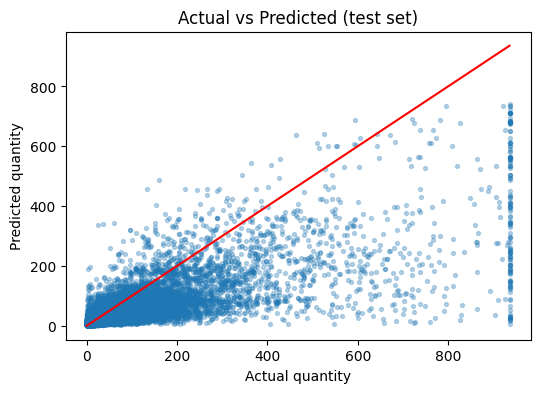

In [46]:
plt.figure(figsize=(6,4))
plt.scatter(y_true, y_pred, alpha=0.3, s=8)
plt.plot([0, max(y_true.max(), y_pred.max())],[0, max(y_true.max(), y_pred.max())], color='red')
plt.xlabel('Actual quantity')
plt.ylabel('Predicted quantity')
plt.title('Actual vs Predicted (test set)')
plt.show()


In [47]:
# sample small set for speed 
sample = test.head(10).copy()

records = []
for _, row in sample.iterrows():
    rec = recommend_price_grid_profit(xgb_model, row, feature_columns,
                               competitor_price=row.get('competitor_price', None),
                               clamp_pct=0.30, price_grid_count=25)
    records.append({
        'StockCode': row['StockCode'],
        'week': row['week'],
        'actual_price': row['avg_price'],
        'actual_qty': row['total_quantity'],
        'actual_revenue': row['total_revenue'],
        'rec_price': rec['price'],
        'rec_pred_qty': rec['predicted_qty'],
        'rec_pred_revenue': rec['predicted_revenue']
    })

bt = pd.DataFrame(records)
bt['rec_vs_actual_pct'] = (bt['rec_pred_revenue'] / bt['actual_revenue'] - 1) * 100

print("Mean revenue change (sample):", bt['rec_vs_actual_pct'].mean().round(2), "%")
print("Median revenue change (sample):", bt['rec_vs_actual_pct'].median().round(2), "%")
display(bt.head(10))


Mean revenue change (sample): 531.85 %
Median revenue change (sample): 128.56 %


,StockCode,week,actual_price,actual_qty,actual_revenue,rec_price,rec_pred_qty,rec_pred_revenue,rec_vs_actual_pct
0,10002,2010-09-20,0.850000,116.0,98.60,1.105000,46.149380,50.995065,-48.280868
1,10002,2010-09-27,0.824000,448.0,328.80,0.844600,182.424637,154.075848,-53.139949
2,10002,2010-10-04,0.850000,48.0,40.80,0.828750,184.750229,153.111752,275.273902
3,10002,2010-10-11,0.835556,474.0,350.90,0.835556,185.753525,155.207390,-55.768769
4,10002,2010-10-18,0.850000,47.0,39.95,0.828750,224.381866,185.956472,365.473021
5,10002,2010-10-25,0.850000,52.0,44.20,0.828750,185.753525,153.943234,248.287859
6,10002,2010-11-01,0.850000,170.0,144.50,0.828750,189.749908,157.255237,8.827153
7,10002,2010-11-08,0.850000,4.0,3.40,0.828750,183.587738,152.148338,4374.951115
8,10002,2010-11-15,0.830000,713.0,534.55,0.830000,170.536392,141.545206,-73.520680
9,10002,2010-11-22,0.850000,47.0,39.95,0.828750,181.462967,150.387434,276.439134


Percent recommendations within ±30%: 90.0 %


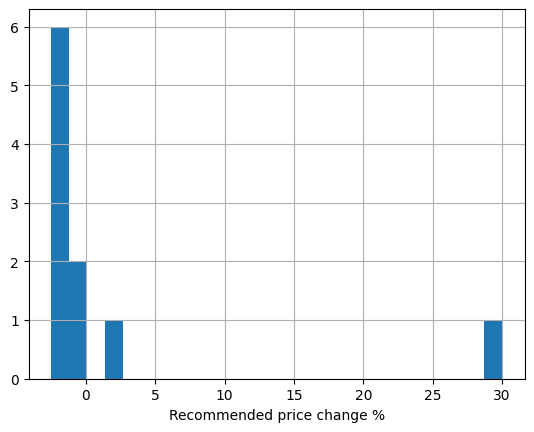

In [48]:
bt['price_change_pct'] = (bt['rec_price'] / bt['actual_price'] - 1) * 100
print("Percent recommendations within ±30%:",
      (bt['price_change_pct'].abs() <= 30).mean()*100, "%")
bt['price_change_pct'].hist(bins=25)
plt.xlabel('Recommended price change %')
plt.show()


In [49]:
print("Any negative predicted qty?", (bt['rec_pred_qty'] < 0).any())


Any negative predicted qty? False


# SAVING MODEL

In [50]:
# Save trained XGBoost model
joblib.dump(xgb_model, "models/xgb_qty_model.joblib")

# Save feature columns
joblib.dump(feature_columns, "models/feature_columns.pkl")


['models/feature_columns.pkl']

# Generate Backtest Reports for Business KPI Summaries

In [53]:
sample_test = test.sample(400, random_state=42)

# Run business KPI evaluation
kpis, bt = evaluate_business_kpis(sample_test, xgb_model, feature_columns, clamp_pct=0.30)

# Save detailed results
os.makedirs("reports", exist_ok=True)
bt.to_csv("reports/backtest_business_kpis.csv", index=False)

print("\n✅ Business KPI Summary (Sample Saved)")
for k, v in kpis.items():
    print(f"{k}: {v:.2f}")



✅ Business KPI Summary (Sample Saved)
Median Profit Uplift %: 125.98
Median Revenue Uplift %: 135.98
Safe Recommendations % (±30%): 87.25
Coverage % (SKUs with recs): 100.00


In [56]:
# Profit-focused KPI evaluation
kpis_profit, bt_profit = evaluate_business_kpis_profit(sample_test, xgb_model, feature_columns, clamp_pct=0.30)

# Save profit-focused results
bt_profit.to_csv("reports/backtest_profit_kpis.csv", index=False)

print("\n✅ Profit-Focused KPI Summary (Sample Saved)")
for k, v in kpis_profit.items():
    print(f"{k}: {v:.2f}")



✅ Profit-Focused KPI Summary (Sample Saved)
Median Profit Uplift % (Main KPI): 125.98
Median Revenue Uplift %: 135.98
Safe Recommendations % (±30%): 87.25
Coverage % (SKUs with recs): 100.00
